In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from keras.models import Model
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

In [3]:
#Load tfds dataset
ds, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
test = ds['test']
train = ds['train']
validation = ds['validation']

#Dataset split sizes
train_size = train.cardinality()
print("Test size:", test.cardinality())
print("Train size", train_size)
print("Validation size", validation.cardinality())

Test size: tf.Tensor(6149, shape=(), dtype=int64)
Train size tf.Tensor(1020, shape=(), dtype=int64)
Validation size tf.Tensor(1020, shape=(), dtype=int64)


In [4]:
#Number of flower classes
num_classes = info.features['label'].num_classes
print("Number of flower classes:", num_classes)

Number of flower classes: 102


In [5]:
#Getting the shape of the images. None = varies in size in height and width. Depth = 3 meaning RGB 3 channel image
print(info.features['image'].shape)

(None, None, 3)


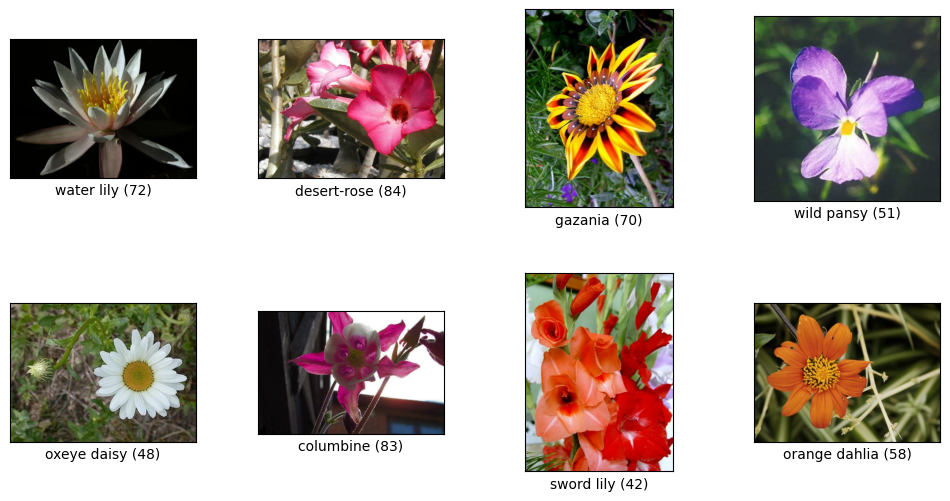

Figure(1200x600)


In [6]:
#Showing some examples of the ds with varying image size and classes
print(tfds.show_examples(train, info, rows=2, cols=4))

In [7]:
batch_size = 16
image_size = 224

#same centre crop every time for test and validation data
def crop_and_resize_test(image, label):
  shape = tf.shape(image)
  #[-1] index is the image channel
  height = shape[-3]
  width = shape[-2]

  #takes shortest dimension and crops square
  if height > width:
      image = tf.image.crop_to_bounding_box(image, offset_height=(height - width) // 2, offset_width=0, target_height=width, target_width=width)
  else:
      image = tf.image.crop_to_bounding_box(image, offset_height=0, offset_width=(width - height) // 2, target_height=height, target_width=height)

  #downsample image
  image = tf.image.resize(image, (image_size, image_size), antialias=False)/255.0
  return image, label

#random crop for training data
def crop_and_resize_train(image, label):
  # label = tf.one_hot(label, num_classes)
  shape = tf.shape(image)
  #[-1] index is the image channel
  height = shape[-3]
  width = shape[-2]

  #takes shortest dimension and randomly crops square
  shortest = tf.math.minimum(height, width)
  image = tf.image.random_crop(image, (shortest, shortest, 3))

  # #random augmentation for train data
  # image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_flip_up_down(image)
  # image = tf.image.random_contrast(image, 0.9, 1.1)
  # image = tf.image.random_brightness(image, 0.2)

  #downsample image
  image = tf.image.resize(image, (image_size, image_size), antialias=False)/255.0

  return image, label

#batch and process data
train_batches = train.cache().shuffle(train_size, reshuffle_each_iteration=False).repeat(60).map(crop_and_resize_train).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_batches = test.map(crop_and_resize_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.cache().map(crop_and_resize_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)

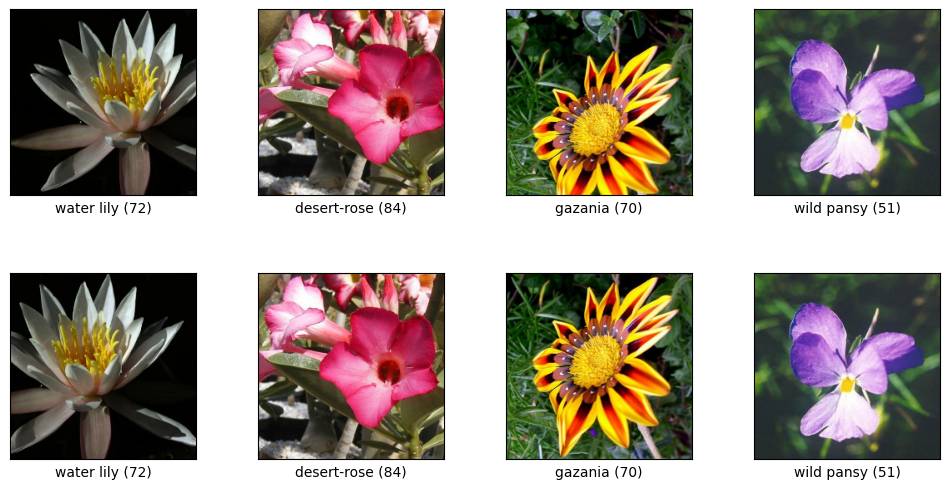

Figure(1200x600)


In [8]:
#Showing some examples of the cropped and resized ds
temp = train.cache().take(4).repeat(2).map(crop_and_resize_train)
print(tfds.show_examples(temp, info, rows=2, cols=4))

In [9]:
#Data augmentation
data_augmentation = keras.Sequential([
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.5, value_range=(0, 1)),
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.3, fill_mode='reflect'),
  # layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
  layers.RandomZoom(0.3, fill_mode='reflect')
])

In [10]:
#Defining our model with its layers
model = keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'),
    layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Conv2D(128, 3, strides=1, padding='same', activation='relu'),
    layers.Conv2D(128, 3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [11]:
#Compiles our model
model.compile(
  # optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
  loss=keras.losses.SparseCategoricalCrossentropy(), #Sparse means labels can be integers rather than one-hot enocded
  metrics=['accuracy']
  )

In [12]:
#Adding callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='checkpoint.h5', save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy'),
    #if no improvement for 5 epochs reduce lr by factor of 0.1
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=3)
]

In [13]:
#Train model and store results
num_epochs = 50
train_history = model.fit(x=train_batches, epochs=num_epochs, callbacks=callbacks, validation_data=validation_batches)

Epoch 1/50
3825/3825 [==============================] - 165s 39ms/step - loss: 3.1266 - accuracy: 0.2144 - val_loss: 2.9009 - val_accuracy: 0.3657 - lr: 1.0000e-04
Epoch 2/50
3825/3825 [==============================] - 143s 37ms/step - loss: 1.7258 - accuracy: 0.5079 - val_loss: 3.0804 - val_accuracy: 0.4167 - lr: 1.0000e-04
Epoch 3/50
3825/3825 [==============================] - 140s 37ms/step - loss: 1.1814 - accuracy: 0.6502 - val_loss: 3.4075 - val_accuracy: 0.4255 - lr: 1.0000e-04
Epoch 4/50
3825/3825 [==============================] - 140s 36ms/step - loss: 0.8501 - accuracy: 0.7419 - val_loss: 3.3849 - val_accuracy: 0.4676 - lr: 1.0000e-04
Epoch 5/50
3825/3825 [==============================] - 140s 37ms/step - loss: 0.6697 - accuracy: 0.7961 - val_loss: 3.5099 - val_accuracy: 0.4784 - lr: 1.0000e-04
Epoch 6/50
3825/3825 [==============================] - 136s 35ms/step - loss: 0.5569 - accuracy: 0.8295 - val_loss: 3.9571 - val_accuracy: 0.4765 - lr: 1.0000e-04
Epoch 7/50
3825/

In [14]:
#Actual number of epochs run
n_epochs = len(train_history.history['loss'])
print(n_epochs)

24


In [15]:
#load in best epoch
model.load_weights('checkpoint.h5')

In [16]:
model.evaluate(test_batches)

385/385 [==============================] - 18s 46ms/step - loss: 5.4117 - accuracy: 0.5277


[5.411703109741211, 0.5277280807495117]

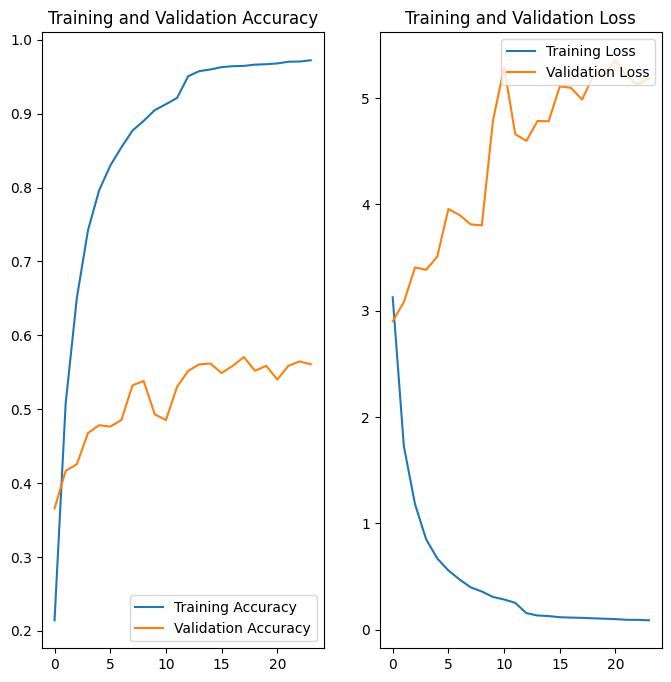

In [17]:
# Creating plots of the loss of accuracy on the training and validation sets
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(n_epochs)

# Training and Validation Accuracy
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

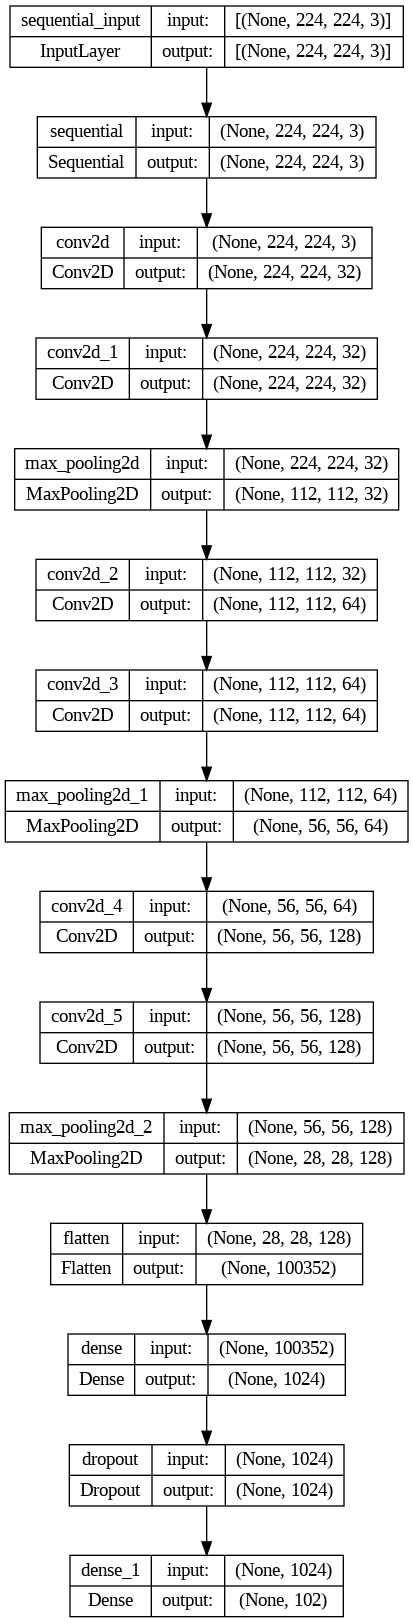

In [18]:
#diagram of model
plot_model(model, show_shapes=True, to_file='model_diagram.png')

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                      

In [20]:
model.save('drive/MyDrive/model2.h5')